In [142]:
""" CIND820 Project  
Sales forecasting using various methods just as XGboost and SARIMA
Dataset from - https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II
"""
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost 
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:

#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail%20II.xlsx"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df = pd.concat(pd.read_excel(url, sheet_name=None), ignore_index=True)


In [3]:
# pathDir = os.getcwd()
# fileName = "Online Retail.xlsx"
# pathFile = "{}{}{}".format(pathDir,os.sep,fileName)
# pathFile
# df = pd.read_excel(pathFile)

In [4]:
#Use this to look at the items with the highest counts to use in our data
df['Description'].value_counts()


WHITE HANGING HEART T-LIGHT HOLDER    5918
REGENCY CAKESTAND 3 TIER              4412
JUMBO BAG RED RETROSPOT               3469
ASSORTED COLOUR BIRD ORNAMENT         2958
PARTY BUNTING                         2765
                                      ... 
broken, uneven bottom                    1
TRAY FOR TV DINNER , DOLLY GIRL          1
Sold as 1 on dotcom                      1
ASSORTED DESIGN GEISHA GIRL MUGS         1
show display                             1
Name: Description, Length: 5698, dtype: int64

In [5]:
# profile = ProfileReport(df)
# profile.to_widgets()

In [6]:
df.describe(include=object)

,Invoice,StockCode,Description,Country
count,1067371,1067371,1062989,1067371
unique,53628,5305,5698,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1350,5829,5918,981330


In [7]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [41]:
#Select items to use in dataset, will use the 5 items with the most units purchased
filterItems = ["JUMBO BAG RED RETROSPOT","LUNCH BAG RED RETROSPOT","PARTY BUNTING","REGENCY CAKESTAND 3 TIER", "WHITE HANGING HEART T-LIGHT HOLDER"]
df = df[df["Description"].isin(filterItems)]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
102,489442,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2009-12-01 09:46:00,2.95,13635.0,United Kingdom
147,489446,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2009-12-01 10:06:00,2.55,13758.0,United Kingdom
271,489465,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2009-12-01 10:52:00,2.55,13767.0,United Kingdom
366,489517,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2009-12-01 11:34:00,2.95,16329.0,United Kingdom
403,489519,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2009-12-01 11:37:00,2.55,17700.0,United Kingdom
...,...,...,...,...,...,...,...,...
1066751,581497,22423,REGENCY CAKESTAND 3 TIER,8,2011-12-09 10:23:00,24.96,NaN,United Kingdom
1066779,581497,47566,PARTY BUNTING,5,2011-12-09 10:23:00,10.79,NaN,United Kingdom
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1067157,581538,20725,LUNCH BAG RED RETROSPOT,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom


In [9]:
#This sums all the quantities of a particular item that was purchased in a day
df2 = df.groupby(['Description', pd.Grouper(key='InvoiceDate', freq='D',label='left')])['Quantity'].sum().reset_index()
df2


,Description,InvoiceDate,Quantity
0,JUMBO BAG RED RETROSPOT,2010-05-14,2
1,JUMBO BAG RED RETROSPOT,2010-05-16,120
2,JUMBO BAG RED RETROSPOT,2010-05-17,0
3,JUMBO BAG RED RETROSPOT,2010-05-18,309
4,JUMBO BAG RED RETROSPOT,2010-05-19,3
...,...,...,...
2477,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-04,8
2478,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,313
2479,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-06,38
2480,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-07,202


In [10]:
#Changing items to its own column using unstack
#Using method found in https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns
#df3 = df2.groupby(["InvoiceDate","Description"])["Quantity"].aggregate("first").unstack().fillna(0)
#df3

#Changing items to its own column using pivot
#Filling the NA values with 0 since they occur because there are no sales on that day for that particular item
df3 = df2.pivot(index="InvoiceDate", columns = "Description", values="Quantity").fillna(0)
df3

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
InvoiceDate,,,,,
2009-12-01,0.0,0.0,6.0,0.0,260.0
2009-12-02,0.0,0.0,9.0,0.0,750.0
2009-12-03,0.0,0.0,0.0,0.0,359.0
2009-12-04,0.0,0.0,15.0,0.0,178.0
2009-12-05,0.0,0.0,0.0,0.0,96.0
...,...,...,...,...,...
2011-12-05,66.0,50.0,16.0,36.0,313.0
2011-12-06,175.0,85.0,21.0,160.0,38.0
2011-12-07,85.0,35.0,3.0,130.0,202.0


In [11]:
#This fills in the days where there were no sales for any product
dateRange = pd.date_range(min(df3.index),max(df3.index))
df4 = df3.reindex(dateRange,fill_value=0)
df4

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
2009-12-01,0.0,0.0,6.0,0.0,260.0
2009-12-02,0.0,0.0,9.0,0.0,750.0
2009-12-03,0.0,0.0,0.0,0.0,359.0
2009-12-04,0.0,0.0,15.0,0.0,178.0
2009-12-05,0.0,0.0,0.0,0.0,96.0
...,...,...,...,...,...
2011-12-05,66.0,50.0,16.0,36.0,313.0
2011-12-06,175.0,85.0,21.0,160.0,38.0
2011-12-07,85.0,35.0,3.0,130.0,202.0
2011-12-08,96.0,52.0,22.0,25.0,58.0


In [12]:
# profile = ProfileReport(df4)
# profile.to_widgets()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

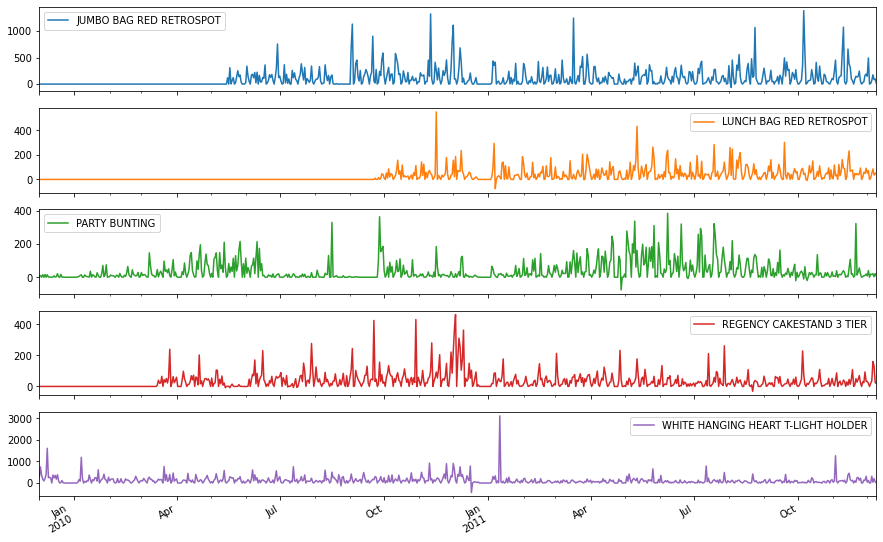

In [149]:
#Plot of the sales of items 
df4.plot(subplots=True, figsize=(15,10))

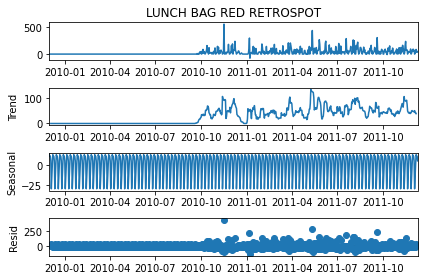

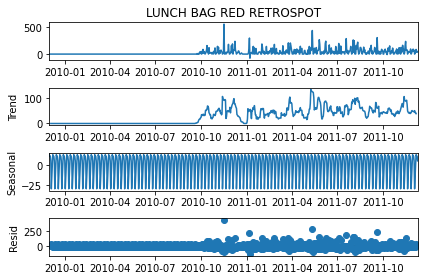

In [168]:
#We can use the seasonal_decompose function from the statsmodel package
#This uses a naive decomposition method where it will assume the model is
#y = level + trend + seasonality + noise
#and it will seperate the trend seasonality and noise for us
decomp1=seasonal_decompose(df4.iloc[:,1],model='additive')
decomp1.plot()

In [139]:
#We used ADF test to see if the data is stationary
# In our case we can use p= 0.05 as a cutoff
#If p is greater than 0.05 then it is not stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
adfuller1 = adfuller(df4.iloc[:,0])
adfuller2 = adfuller(df4.iloc[:,1])
adfuller3 = adfuller(df4.iloc[:,2])
adfuller4 = adfuller(df4.iloc[:,3])
adfuller5 = adfuller(df4.iloc[:,4])

for item in range(5):
    print("\n",filterItems[item])
    result= adfuller(df4.iloc[:,item])
    print("ADF Statistic: ",result[0])
    print("p=value: ",result[1])
    for key, value in result[4].items():
        print(key," : ",value)
    


 JUMBO BAG RED RETROSPOT
ADF Statistic:  -3.582764365533264
p=value:  0.006099215222848656
1%  :  -3.439477677285233
5%  :  -2.865568186630048
10%  :  -2.5689150720653977

 LUNCH BAG RED RETROSPOT
ADF Statistic:  -2.661750084392472
p=value:  0.08089424739759998
1%  :  -3.4394144152232995
5%  :  -2.8655403100177566
10%  :  -2.5689002207655443

 PARTY BUNTING
ADF Statistic:  -2.584802479760175
p=value:  0.09617914262088229
1%  :  -3.439490435810785
5%  :  -2.8655738086413374
10%  :  -2.568918067209286

 REGENCY CAKESTAND 3 TIER
ADF Statistic:  -3.589549705580556
p=value:  0.00596398668869175
1%  :  -3.439490435810785
5%  :  -2.8655738086413374
10%  :  -2.568918067209286

 WHITE HANGING HEART T-LIGHT HOLDER
ADF Statistic:  -7.577549163033771
p=value:  2.7361126798661202e-11
1%  :  -3.4393273074073045
5%  :  -2.8655019247555154
10%  :  -2.568879771109793


In [57]:
#Since the second and third item are not stationary we can log transform our data
dflog=df4.copy()

In [111]:
dflog=np.log(df4)
dflog.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
dflog = dflog.fillna(0)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


AttributeError: module 'numpy' has no attribute 'isna'

In [112]:
#Creates a training and test split with 70% training and 30% test. 
trainSize= 0.7

#Depending on if we are using untransformed or log transformed data we can uncomment a different line

#Using untransformed data
#train, test =train_test_split(df4, train_size= trainSize, shuffle= False)

#Using log transformed data
train, test =train_test_split(dflog, train_size= trainSize, shuffle= False)


 JUMBO BAG RED RETROSPOT
ADF Statistic:  -3.582764365533264
p=value:  0.006099215222848656
1%  :  -3.439477677285233
5%  :  -2.865568186630048
10%  :  -2.5689150720653977

 LUNCH BAG RED RETROSPOT
ADF Statistic:  -2.661750084392472
p=value:  0.08089424739759998
1%  :  -3.4394144152232995
5%  :  -2.8655403100177566
10%  :  -2.5689002207655443

 PARTY BUNTING
ADF Statistic:  -2.584802479760175
p=value:  0.09617914262088229
1%  :  -3.439490435810785
5%  :  -2.8655738086413374
10%  :  -2.568918067209286

 REGENCY CAKESTAND 3 TIER
ADF Statistic:  -3.589549705580556
p=value:  0.00596398668869175
1%  :  -3.439490435810785
5%  :  -2.8655738086413374
10%  :  -2.568918067209286

 WHITE HANGING HEART T-LIGHT HOLDER
ADF Statistic:  -7.577549163033771
p=value:  2.7361126798661202e-11
1%  :  -3.4393273074073045
5%  :  -2.8655019247555154
10%  :  -2.568879771109793


In [114]:
#Create variables for training test start and end dates 
forecastStart=test.index.min()
forecastEnd=test.index.max()

In [115]:
#Creates the ARIMA models for the 5 items
arimaModel1 = ARIMA(train.iloc[:,0],order= (1,1,1)).fit()
arimaModel2 = ARIMA(train.iloc[:,1],order= (1,1,1)).fit()
arimaModel3 = ARIMA(train.iloc[:,2],order= (1,1,1)).fit()
arimaModel4 = ARIMA(train.iloc[:,3],order= (1,1,1)).fit()
arimaModel5 = ARIMA(train.iloc[:,4],order= (1,1,1)).fit()

In [97]:
arimaModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                 
=====================================================================================
Dep. Variable:     D.JUMBO BAG RED RETROSPOT   No. Observations:                  516
Model:                        ARIMA(1, 1, 1)   Log Likelihood               -1038.137
Method:                              css-mle   S.D. of innovations              1.807
Date:                       Mon, 05 Jul 2021   AIC                           2084.275
Time:                               22:54:48   BIC                           2101.259
Sample:                           12-02-2009   HQIC                          2090.930
                                - 05-01-2011                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0057      0.009      0.598      0.550      -0.013       0.024
ar.L1.D.JUMBO BAG RED RETROSPOT     0.2152      0.050      4.309      0.000       0.117       0.313
ma.L1.D.JUMBO BAG RED RETROSPOT    -0.9083      0.021    -42.251      0.000      -0.950      -0.866
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.6466           +0.0000j            4.6466            0.0000
MA.1            1.1009           +0.0000j            1.1009            0.0000
-----------------------------------------------------------------------------
"""

In [116]:
#ARIMA forecasts dynamic = true makes it so it uses previous forecasts to predict the forecasts after
arimaModel1Forecast= arimaModel1.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel2Forecast= arimaModel2.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel3Forecast= arimaModel3.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel4Forecast= arimaModel4.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel5Forecast= arimaModel5.predict(start=forecastStart,end=forecastEnd, dynamic= True)

In [117]:
#Creates a copy of the test dataframe we are going to add predictions to
testForecasts= test.copy()

In [118]:
#Adds an ARIMA forecast column to the testForecast dataframe we made
testForecasts["ARIMA Forecast 1 Jumbo"]=arimaModel1Forecast
testForecasts["ARIMA Forecast 2 Lunch"]=arimaModel2Forecast
testForecasts["ARIMA Forecast 3 Party"]=arimaModel3Forecast
testForecasts["ARIMA Forecast 4 Regency"]=arimaModel4Forecast
testForecasts["ARIMA Forecast 5 White"]=arimaModel5Forecast
testForecasts

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER,ARIMA Forecast 1 Jumbo,ARIMA Forecast 2 Lunch,ARIMA Forecast 3 Party,ARIMA Forecast 4 Regency,ARIMA Forecast 5 White
2011-05-02,0.000000,0.000000,0.000000,0.000000,0.000000,-1.316700,-0.113122,-0.439198,0.442755,0.622730
2011-05-03,3.931826,4.317488,5.631212,3.526361,5.758902,-0.278921,-0.012238,-0.071971,0.078807,0.105434
2011-05-04,3.871201,0.000000,5.379897,2.397895,4.442651,-0.055580,0.001947,-0.009936,0.016900,0.016872
2011-05-05,4.343805,3.637586,5.043425,3.970292,6.042633,-0.007515,0.003941,0.000543,0.006370,0.001710
2011-05-06,4.543295,4.941642,4.882802,3.688879,5.187386,0.002829,0.004222,0.002313,0.004578,-0.000886
...,...,...,...,...,...,...,...,...,...,...
2011-12-05,4.189655,3.912023,2.772589,3.583519,5.746203,0.005666,0.004268,0.002673,0.004211,-0.001422
2011-12-06,5.164786,4.442651,3.044522,5.075174,3.637586,0.005666,0.004268,0.002673,0.004211,-0.001422
2011-12-07,4.442651,3.555348,1.098612,4.867534,5.308268,0.005666,0.004268,0.002673,0.004211,-0.001422
2011-12-08,4.564348,3.951244,3.091042,3.218876,4.060443,0.005666,0.004268,0.002673,0.004211,-0.001422


In [119]:
#Create and show RMSE MAE and MAPE for each ARIMA forecast on each item
arimaModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],arimaModel1Forecast)
arimaModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],arimaModel1Forecast)
arimaModel1MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,0],arimaModel1Forecast)
print("JUMBO BAG RED RETROSPOT \n RMSE: ",arimaModel1RMSE,"\n","MAE: ",arimaModel1MAE,"\n","MAPE: ",arimaModel1MAPE,"\n")

arimaModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],arimaModel2Forecast)
arimaModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],arimaModel2Forecast)
arimaModel2MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,1],arimaModel2Forecast)
print("LUNCH BAG RED RETROSPOT \n RMSE: ",arimaModel2RMSE,"\n","MAE: ",arimaModel2MAE,"\n","MAPE: ",arimaModel2MAPE,"\n")

arimaModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],arimaModel3Forecast)
arimaModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],arimaModel3Forecast)
arimaModel3MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,2],arimaModel3Forecast)
print("PARTY BUNTING \n RMSE: ",arimaModel3RMSE,"\n","MAE: ",arimaModel3MAE,"\n","MAPE: ",arimaModel3MAPE,"\n")

arimaModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],arimaModel4Forecast)
arimaModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],arimaModel4Forecast)
arimaModel4MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,3],arimaModel4Forecast)
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",arimaModel4RMSE,"\n","MAE: ",arimaModel4MAE,"\n","MAPE: ",arimaModel4MAPE,"\n")

arimaModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],arimaModel5Forecast)
arimaModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],arimaModel5Forecast)
arimaModel5MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,4],arimaModel5Forecast)
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",arimaModel5RMSE,"\n","MAE: ",arimaModel5MAE,"\n","MAPE: ",arimaModel5MAPE,"\n")


JUMBO BAG RED RETROSPOT 
 RMSE:  18.931326559390623 
 MAE:  3.8841809814646173 
 MAPE:  30606660371312.51 

LUNCH BAG RED RETROSPOT 
 RMSE:  13.219697330774904 
 MAE:  3.226649416644875 
 MAPE:  5364461799534.185 

PARTY BUNTING 
 RMSE:  12.123681610044738 
 MAE:  2.9996501315036883 
 MAPE:  11077767353582.393 

REGENCY CAKESTAND 3 TIER 
 RMSE:  9.2109597295006 
 MAE:  2.663202516938892 
 MAPE:  12144250697312.367 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  15.87443393622255 
 MAE:  3.563011587393283 
 MAPE:  13611936975897.744 



In [120]:
#Creates the SARIMA models
sarimaModel1 = sm.tsa.statespace.SARIMAX(train.iloc[:,0],order= (1,1,1),seasonal_order=(1,1,1,7)).fit()
sarimaModel2 = sm.tsa.statespace.SARIMAX(train.iloc[:,1],order= (1,1,1),seasonal_order=(1,1,1,7)).fit()
sarimaModel3 = sm.tsa.statespace.SARIMAX(train.iloc[:,2],order= (1,1,1),seasonal_order=(1,1,1,7)).fit()
sarimaModel4 = sm.tsa.statespace.SARIMAX(train.iloc[:,3],order= (1,1,1),seasonal_order=(1,1,1,7)).fit()
sarimaModel5 = sm.tsa.statespace.SARIMAX(train.iloc[:,4],order= (1,1,1),seasonal_order=(1,1,1,7)).fit()

In [121]:
#SARIMA model forecasts
sarimaModel1Forecast= sarimaModel1.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 1 Jumbo"]=sarimaModel1Forecast
sarimaModel2Forecast= sarimaModel2.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 2 Lunch"]=sarimaModel1Forecast
sarimaModel3Forecast= sarimaModel3.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 3 Party"]=sarimaModel1Forecast
sarimaModel4Forecast= sarimaModel4.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 4 Regency"]=sarimaModel1Forecast
sarimaModel5Forecast= sarimaModel5.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 5 White"]=sarimaModel1Forecast


In [122]:
#SARIMA Model evaluation metrics
sarimaModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],sarimaModel1Forecast)
sarimaModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],sarimaModel1Forecast)
sarimaModel1MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,0],sarimaModel1Forecast)
print("JUMBO BAG RED RETROSPOT \n RMSE: ",sarimaModel1RMSE,"\n","MAE: ",sarimaModel1MAE,"\n","MAPE: ",sarimaModel1MAPE,"\n")

sarimaModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],sarimaModel2Forecast)
sarimaModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],sarimaModel2Forecast)
sarimaModel2MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,1],sarimaModel2Forecast)
print("LUNCH BAG RED RETROSPOT \n RMSE: ",sarimaModel2RMSE,"\n","MAE: ",sarimaModel2MAE,"\n","MAPE: ",sarimaModel2MAPE,"\n")

sarimaModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],sarimaModel3Forecast)
sarimaModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],sarimaModel3Forecast)
sarimaModel3MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,2],sarimaModel3Forecast)
print("PARTY BUNTING \n RMSE: ",sarimaModel3RMSE,"\n","MAE: ",sarimaModel3MAE,"\n","MAPE: ",sarimaModel3MAPE,"\n")

sarimaModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],sarimaModel4Forecast)
sarimaModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],sarimaModel4Forecast)
sarimaModel4MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,3],sarimaModel4Forecast)
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",sarimaModel4RMSE,"\n","MAE: ",sarimaModel4MAE,"\n","MAPE: ",sarimaModel4MAPE,"\n")

sarimaModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],sarimaModel5Forecast)
sarimaModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],sarimaModel5Forecast)
sarimaModel5MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,4],sarimaModel5Forecast)
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",sarimaModel5RMSE,"\n","MAE: ",sarimaModel5MAE,"\n","MAPE: ",sarimaModel5MAPE,"\n")


JUMBO BAG RED RETROSPOT 
 RMSE:  5.599505789211242 
 MAE:  2.0987536043369825 
 MAPE:  1108698941576733.4 

LUNCH BAG RED RETROSPOT 
 RMSE:  7.167367954649591 
 MAE:  2.431793607550966 
 MAPE:  1275984029613291.8 

PARTY BUNTING 
 RMSE:  2.2548034344833052 
 MAE:  1.1994010953894194 
 MAPE:  650214754539235.6 

REGENCY CAKESTAND 3 TIER 
 RMSE:  5.758028943430874 
 MAE:  2.101283083964739 
 MAPE:  1393316399096546.5 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  4.928812071078017 
 MAE:  1.9975523802047472 
 MAPE:  1407089503672021.2 



In [123]:
#Adds SARIMA forecast column to the forecast dataframe
testForecasts["SARIMA Forecast 1 Jumbo"]=sarimaModel1Forecast
testForecasts["SARIMA Forecast 2 Lunch"]=sarimaModel2Forecast
testForecasts["SARIMA Forecast 3 Party"]=sarimaModel3Forecast
testForecasts["SARIMA Forecast 4 Regency"]=sarimaModel4Forecast
testForecasts["SARIMA Forecast 5 White"]=sarimaModel5Forecast

In [124]:
# XGBoost and LightGBM require features
#Since our data we are using in the ARIMA and SARIMA models are univariate
#We will creates features with the datetime information


def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [125]:
#Uses the function above to create the X and Y features for each item for xgBoost and LightGBM
xTrain1, yTrain1= create_features(train,label="JUMBO BAG RED RETROSPOT")
xTest1, yTest1= create_features(test,label="JUMBO BAG RED RETROSPOT")

xTrain2, yTrain2= create_features(train,label="LUNCH BAG RED RETROSPOT")
xTest2, yTest2= create_features(test,label="LUNCH BAG RED RETROSPOT")

xTrain3, yTrain3= create_features(train,label="PARTY BUNTING")
xTest3, yTest3= create_features(test,label="PARTY BUNTING")

xTrain4, yTrain4= create_features(train,label="REGENCY CAKESTAND 3 TIER")
xTest4, yTest4= create_features(test,label="REGENCY CAKESTAND 3 TIER")

xTrain5, yTrain5= create_features(train,label="WHITE HANGING HEART T-LIGHT HOLDER")
xTest5, yTest5= create_features(test,label="WHITE HANGING HEART T-LIGHT HOLDER")

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [126]:
#Creates xgBoost Model and forecast 
xgboostModel1= xgboost.XGBRegressor(n_estimators= 1000).fit(xTrain1, yTrain1, eval_set= [(xTrain1, yTrain1), (xTest1, yTest1)], early_stopping_rounds= 50, verbose= False)
xgboostModel1Forecast= xgboostModel1.predict(xTest1)

xgboostModel2= xgboost.XGBRegressor(n_estimators= 1000).fit(xTrain2, yTrain2, eval_set= [(xTrain2, yTrain2), (xTest2, yTest2)], early_stopping_rounds= 50, verbose= False)
xgboostModel2Forecast= xgboostModel2.predict(xTest2)

xgboostModel3= xgboost.XGBRegressor(n_estimators= 1000).fit(xTrain3, yTrain3, eval_set= [(xTrain3, yTrain3), (xTest3, yTest3)], early_stopping_rounds= 50, verbose= False)
xgboostModel3Forecast= xgboostModel3.predict(xTest3)

xgboostModel4= xgboost.XGBRegressor(n_estimators= 1000).fit(xTrain2, yTrain2, eval_set= [(xTrain4, yTrain4), (xTest4, yTest4)], early_stopping_rounds= 50, verbose= False)
xgboostModel4Forecast= xgboostModel4.predict(xTest4)

xgboostModel5= xgboost.XGBRegressor(n_estimators= 1000).fit(xTrain2, yTrain2, eval_set= [(xTrain5, yTrain5), (xTest5, yTest5)], early_stopping_rounds= 50, verbose= False)
xgboostModel5Forecast= xgboostModel5.predict(xTest5)




In [127]:
#XGBoost evaluation metrics 
xgboostModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],xgboostModel1Forecast)
xgboostModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],xgboostModel1Forecast)
xgboostModel1MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,0],xgboostModel1Forecast)
print("JUMBO BAG RED RETROSPOT \n RMSE: ",xgboostModel1RMSE,"\n","MAE: ",xgboostModel1MAE,"\n","MAPE: ",xgboostModel1MAPE,"\n")

xgboostModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],xgboostModel2Forecast)
xgboostModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],xgboostModel2Forecast)
xgboostModel2MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,1],xgboostModel2Forecast)
print("LUNCH BAG RED RETROSPOT \n RMSE: ",xgboostModel2RMSE,"\n","MAE: ",xgboostModel2MAE,"\n","MAPE: ",xgboostModel2MAPE,"\n")

xgboostModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],xgboostModel3Forecast)
xgboostModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],xgboostModel3Forecast)
xgboostModel3MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,2],xgboostModel3Forecast)
print("PARTY BUNTING \n RMSE: ",xgboostModel3RMSE,"\n","MAE: ",xgboostModel3MAE,"\n","MAPE: ",xgboostModel3MAPE,"\n")

xgboostModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],xgboostModel4Forecast)
xgboostModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],xgboostModel4Forecast)
xgboostModel4MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,3],xgboostModel4Forecast)
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",xgboostModel4RMSE,"\n","MAE: ",xgboostModel4MAE,"\n","MAPE: ",xgboostModel4MAPE,"\n")

xgboostModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],xgboostModel5Forecast)
xgboostModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],xgboostModel5Forecast)
xgboostModel5MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,4],xgboostModel5Forecast)
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",xgboostModel5RMSE,"\n","MAE: ",xgboostModel5MAE,"\n","MAPE: ",xgboostModel5MAPE,"\n")



JUMBO BAG RED RETROSPOT 
 RMSE:  2.276938140716217 
 MAE:  1.0557733848160893 
 MAPE:  264384581553179.84 

LUNCH BAG RED RETROSPOT 
 RMSE:  5.643714018574623 
 MAE:  2.020592948493509 
 MAPE:  273924626961454.62 

PARTY BUNTING 
 RMSE:  4.179489084507571 
 MAE:  1.5530269125828926 
 MAPE:  448035306458435.25 

REGENCY CAKESTAND 3 TIER 
 RMSE:  3.359844937360797 
 MAE:  1.4518006564927983 
 MAPE:  252821383295087.06 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  7.07588270854947 
 MAE:  2.25081680785347 
 MAPE:  184028739991829.25 



In [128]:
#Adds xgBoost coulmn to forecast dataframe
testForecasts["xgBoost Forecast 1 Jumbo"]=xgboostModel1Forecast
testForecasts["xgBoost Forecast 2 Lunch"]=xgboostModel2Forecast
testForecasts["xgBoost Forecast 3 Party"]=xgboostModel3Forecast
testForecasts["xgBoost Forecast 4 Regency"]=xgboostModel4Forecast
testForecasts["xgBoost Forecast 5 White"]=xgboostModel5Forecast

Text(0.5, 1.0, 'xgBoost')

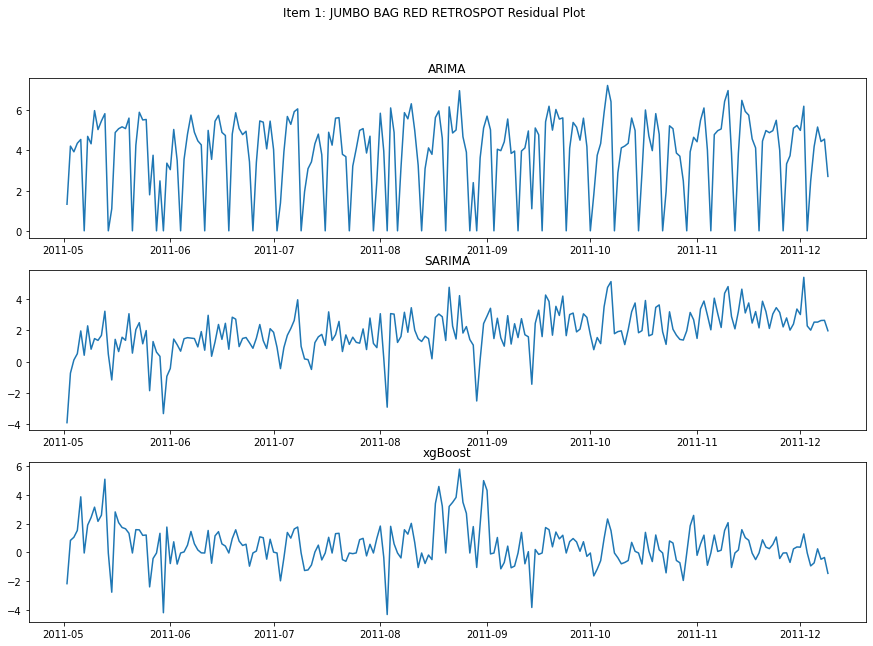

In [129]:
#Plot of residuals for item 1
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 1: JUMBO BAG RED RETROSPOT Residual Plot')
ax1.plot(test.iloc[:,0]- arimaModel1Forecast)
ax1.set_title("ARIMA")
ax2.plot(test.iloc[:,0]- sarimaModel1Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,0]- testForecasts['xgBoost Forecast 1 Jumbo'])
ax3.set_title("xgBoost")


Text(0.5, 1.0, 'xgBoost')

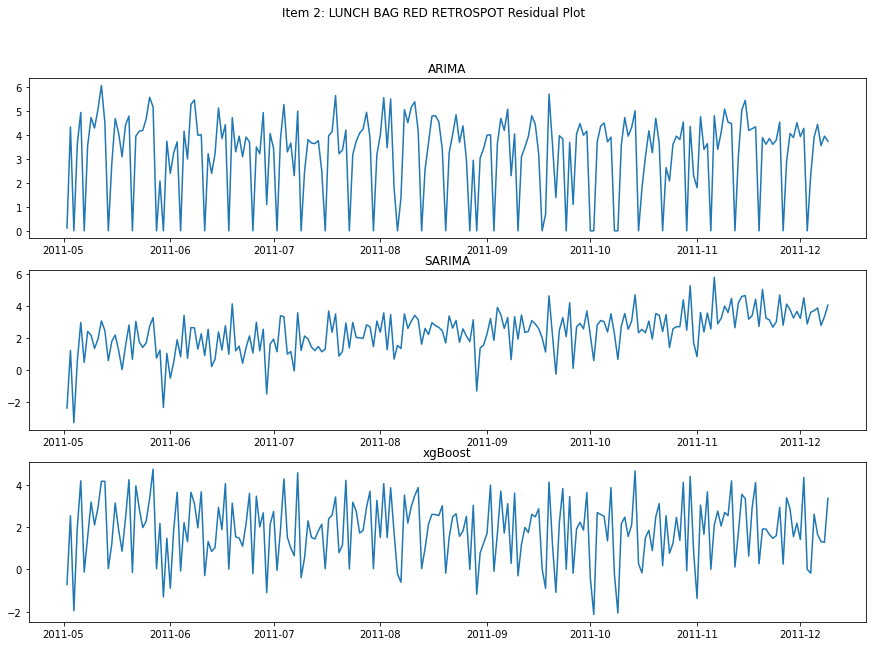

In [130]:
#Plot of the residuals for LUNCH BAG RED RETROSPOT
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 2: LUNCH BAG RED RETROSPOT Residual Plot')
ax1.plot(test.iloc[:,1]- arimaModel2Forecast)
ax1.set_title("ARIMA")
ax2.plot(test.iloc[:,1]- sarimaModel2Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,1]- testForecasts['xgBoost Forecast 2 Lunch'])
ax3.set_title("xgBoost")

Text(0.5, 1.0, 'xgBoost')

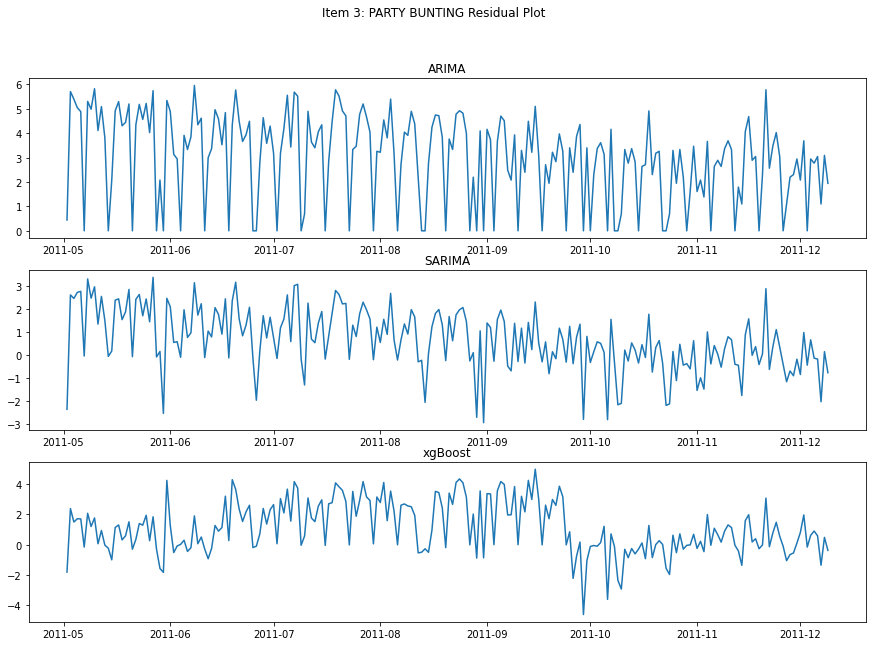

In [131]:
#Plot of the residuals for PARTY BUNTING
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 3: PARTY BUNTING Residual Plot')
ax1.plot(test.iloc[:,2]- arimaModel3Forecast)
ax1.set_title("ARIMA")
ax2.plot(test.iloc[:,2]- sarimaModel3Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,2]- testForecasts['xgBoost Forecast 3 Party'])
ax3.set_title("xgBoost")

Text(0.5, 1.0, 'xgBoost')

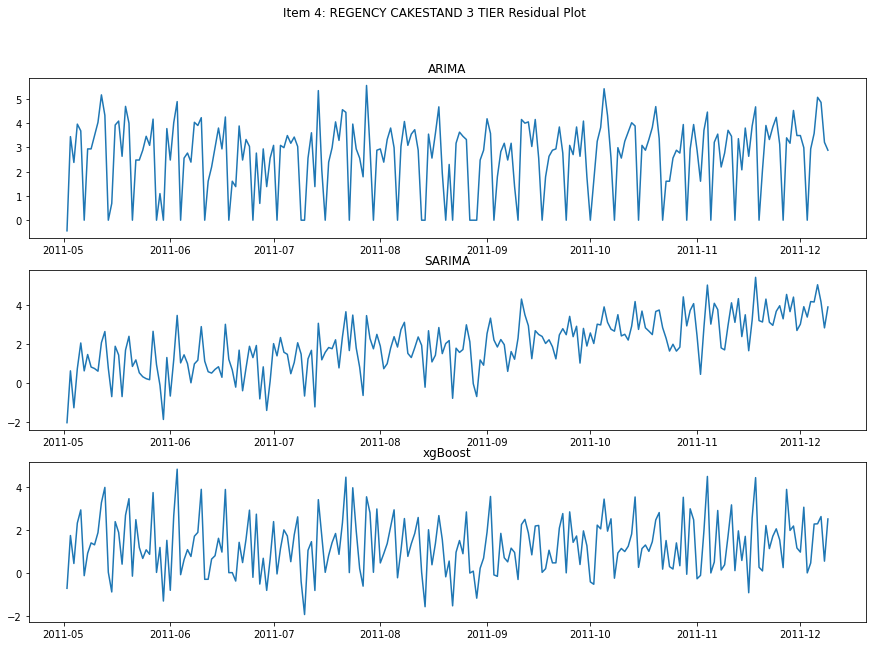

In [132]:
#Plot of the residuals for REGENCY CAKESTAND 3 TIER
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 4: REGENCY CAKESTAND 3 TIER Residual Plot')
ax1.plot(test.iloc[:,3]- arimaModel4Forecast)
ax1.set_title("ARIMA")
ax2.plot(test.iloc[:,3]- sarimaModel4Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,3]- testForecasts['xgBoost Forecast 4 Regency'])
ax3.set_title("xgBoost")

Text(0.5, 1.0, 'xgBoost')

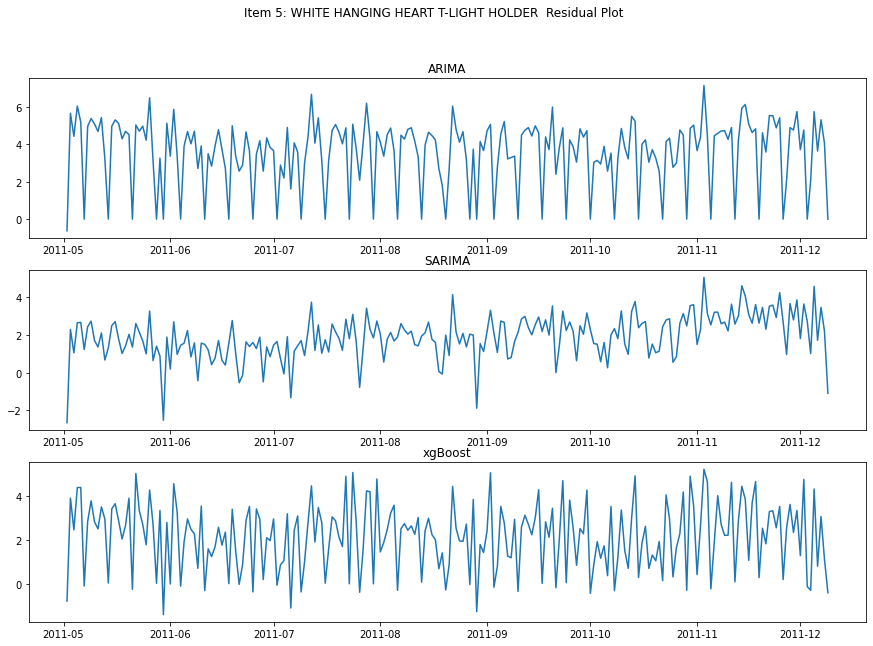

In [133]:
#Plot of the residuals for WHITE HANGING HEART T-LIGHT HOLDER
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 5: WHITE HANGING HEART T-LIGHT HOLDER  Residual Plot')
ax1.plot(test.iloc[:,4]- arimaModel5Forecast)
ax1.set_title("ARIMA")
ax2.plot(test.iloc[:,4]- sarimaModel5Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,4]- testForecasts['xgBoost Forecast 5 White'])
ax3.set_title("xgBoost")

Text(0.5, 1.0, 'xgBoost')

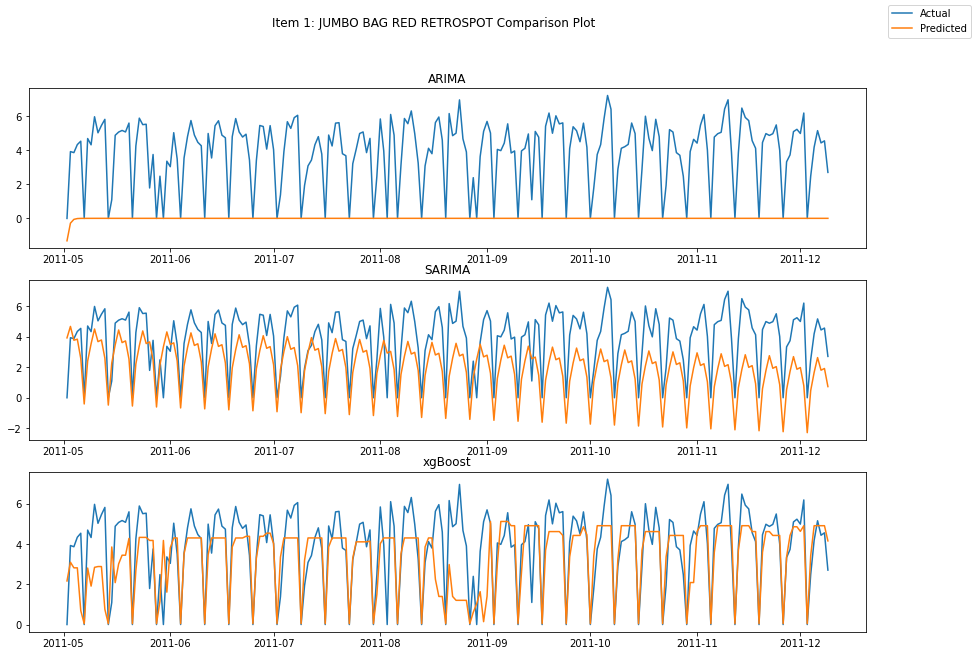

In [134]:
#Graph of predicted valeus vs actual values for Item 1
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 1: JUMBO BAG RED RETROSPOT Comparison Plot')
ax1.plot(test.iloc[:,0])
ax1.plot(arimaModel1Forecast)
ax1.set_title("ARIMA")
fig.legend(["Actual", "Predicted"])
ax2.plot(test.iloc[:,0])
ax2.plot(sarimaModel1Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,0])
ax3.plot(testForecasts['xgBoost Forecast 1 Jumbo'])
# ax3.plot(xgboostModel1Forecast)
ax3.set_title("xgBoost")


Text(0.5, 1.0, 'xgBoost')

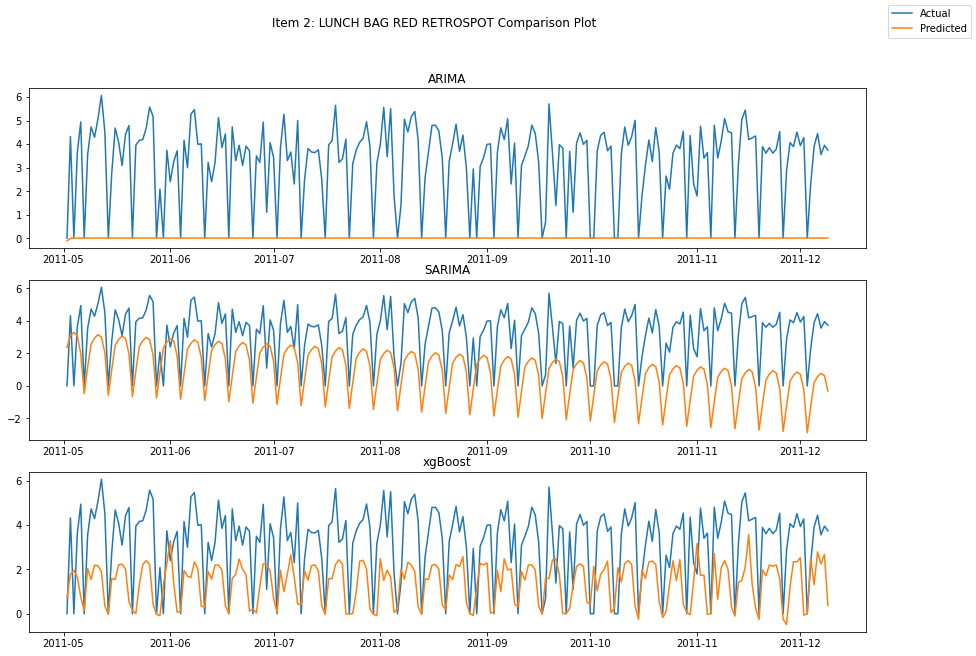

In [135]:
#Graph of predicted valeus vs actual values for Item 2
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 2: LUNCH BAG RED RETROSPOT Comparison Plot')
ax1.plot(test.iloc[:,1])
ax1.plot(arimaModel2Forecast)
ax1.set_title("ARIMA")
fig.legend(["Actual", "Predicted"])
ax2.plot(test.iloc[:,1])
ax2.plot(sarimaModel2Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,1])
ax3.plot(testForecasts['xgBoost Forecast 2 Lunch'])
# ax3.plot(xgboostModel1Forecast)
ax3.set_title("xgBoost")


Text(0.5, 1.0, 'xgBoost')

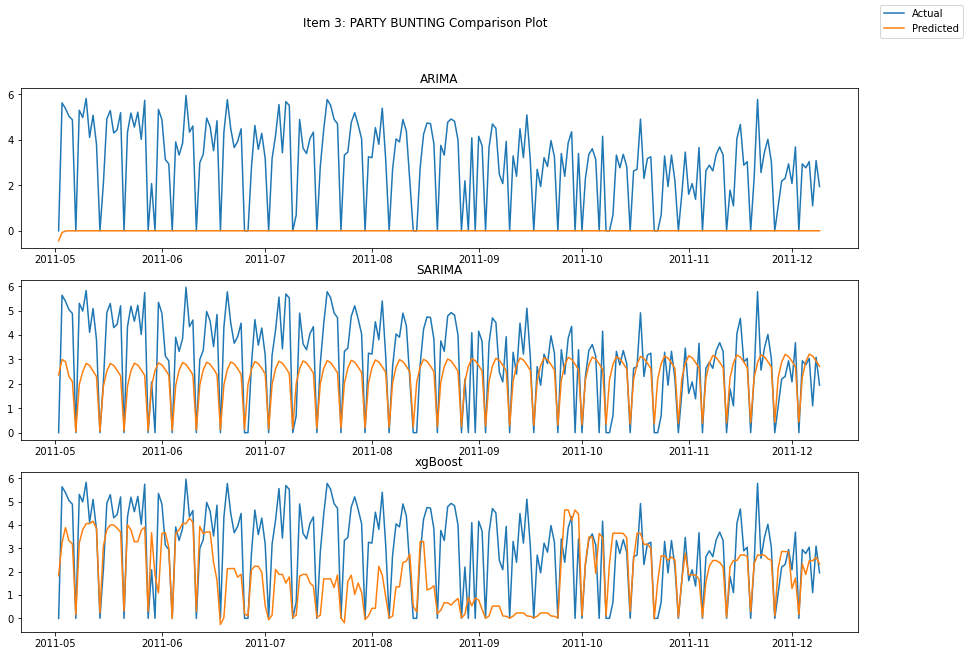

In [136]:
#Graph of predicted valeus vs actual values for Item 3
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 3: PARTY BUNTING Comparison Plot')
ax1.plot(test.iloc[:,2])
ax1.plot(arimaModel3Forecast)
ax1.set_title("ARIMA")
fig.legend(["Actual", "Predicted"])
ax2.plot(test.iloc[:,2])
ax2.plot(sarimaModel3Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,2])
ax3.plot(testForecasts['xgBoost Forecast 3 Party'])
# ax3.plot(xgboostModel1Forecast)
ax3.set_title("xgBoost")

Text(0.5, 1.0, 'xgBoost')

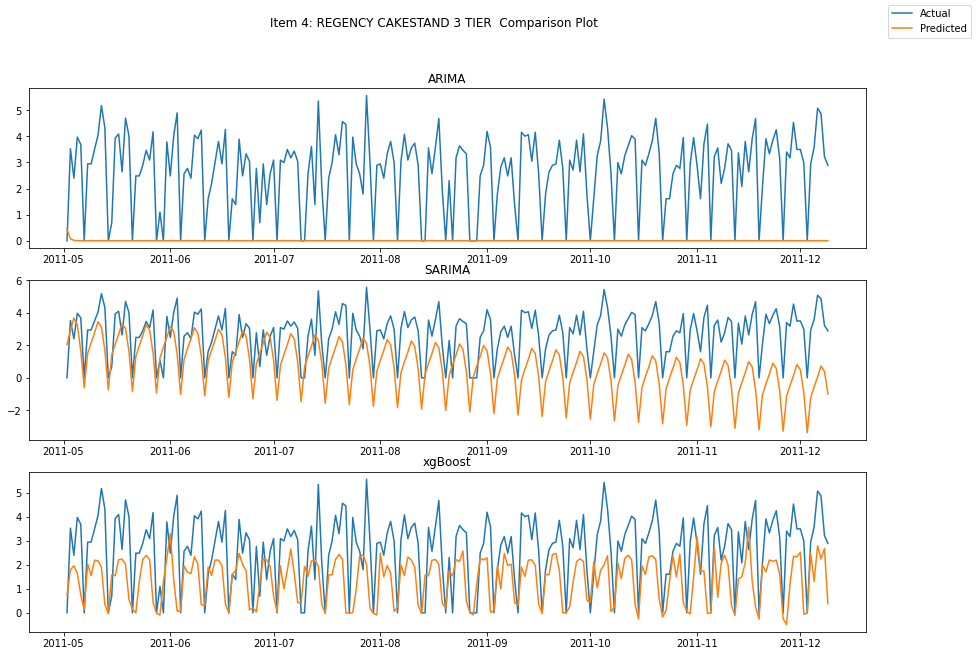

In [137]:
#Graph of predicted valeus vs actual values for Item 4
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 4: REGENCY CAKESTAND 3 TIER  Comparison Plot')
ax1.plot(test.iloc[:,3])
ax1.plot(arimaModel4Forecast)
ax1.set_title("ARIMA")
fig.legend(["Actual", "Predicted"])
ax2.plot(test.iloc[:,3])
ax2.plot(sarimaModel4Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,3])
ax3.plot(testForecasts['xgBoost Forecast 4 Regency'])
# ax3.plot(xgboostModel1Forecast)
ax3.set_title("xgBoost")

Text(0.5, 1.0, 'xgBoost')

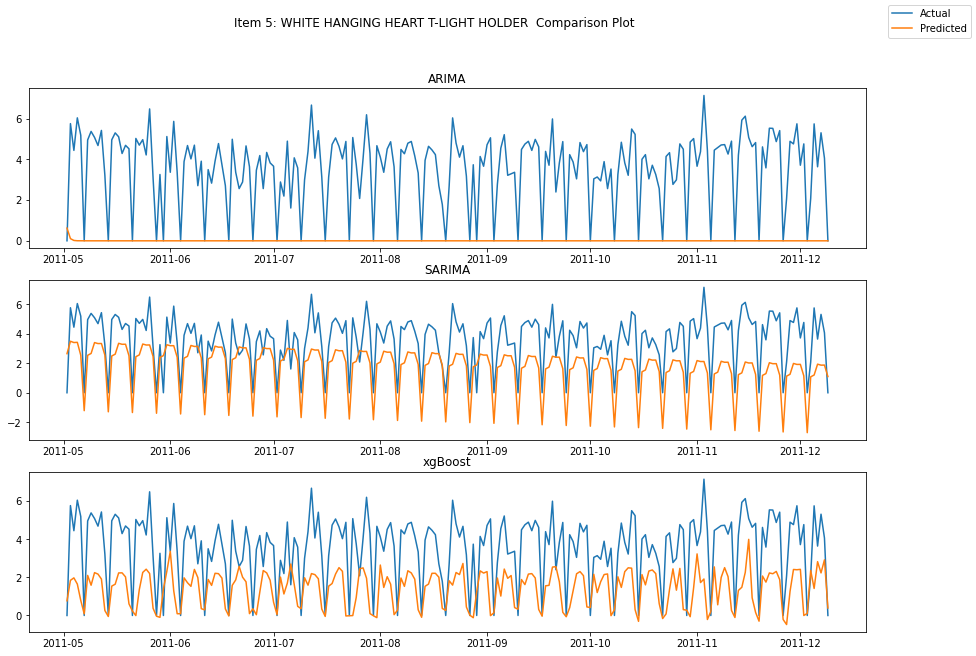

In [138]:
#Graph of predicted valeus vs actual values for Item 5
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 5: WHITE HANGING HEART T-LIGHT HOLDER  Comparison Plot')
ax1.plot(test.iloc[:,4])
ax1.plot(arimaModel5Forecast)
ax1.set_title("ARIMA")
fig.legend(["Actual", "Predicted"])
ax2.plot(test.iloc[:,4])
ax2.plot(sarimaModel5Forecast)
ax2.set_title("SARIMA")
ax3.plot(test.iloc[:,4])
ax3.plot(testForecasts['xgBoost Forecast 5 White'])
# ax3.plot(xgboostModel1Forecast)
ax3.set_title("xgBoost")